In [22]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.regularizers import l2
from sklearn.preprocessing import StandardScaler
from scikeras.wrappers import KerasClassifier
from sklearn.model_selection import GridSearchCV
import pandas as pd


In [23]:
from tensorflow.keras.metrics import Precision, Recall, AUC

## Load the dataset

Fit the model using **One-hot missing values alone**

In [24]:
df = pd.read_csv('GDSI_OpenDataset_Final_cleaned_OH_imputed.csv')
# set secret_name as index
df.set_index('secret_name', inplace=True)
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1141 entries, C_1005 to P_992
Columns: 107 entries, covid19_sympt_chills_no to covid19_outcome_levels_2_2
dtypes: int64(107)
memory usage: 962.7+ KB


In [25]:
X = df.drop(columns=['ms_type2_relapsing_remitting', 'ms_type2_progressive_MS','ms_type2_other'])
Y = df[['ms_type2_relapsing_remitting', 'ms_type2_progressive_MS','ms_type2_other']]

# train test split
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.3, random_state=123)

# Standardize data
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

X_train = X_train.astype('float32')
X_test = X_test.astype('float32')

# Ensure target variables are numpy arrays of type float32
y_train = y_train.values.astype('float32')
y_test = y_test.values.astype('float32')


In [26]:
def create_model(units=[64, 128], dropout_rate=0.2, learning_rate=0.0001, l2_reg=0.01):
    model = Sequential()
    
    # First layer
    model.add(Dense(units[0], input_dim=X_train.shape[1], activation='relu', 
                    kernel_regularizer=l2(l2_reg)))
    model.add(BatchNormalization())
    model.add(Dropout(dropout_rate))
    
    # Second layer
    model.add(Dense(units[1], activation='relu', kernel_regularizer=l2(l2_reg)))
    model.add(BatchNormalization())
    model.add(Dropout(dropout_rate))
    
    # Output layer
    model.add(Dense(3, activation='softmax'))
    
    optimizer = Adam(learning_rate=learning_rate)
    model.compile(optimizer=optimizer, 
                  loss='categorical_crossentropy', 
                  metrics=['accuracy'])
    
    return model
model = KerasClassifier(build_fn=create_model, verbose=0)

## Hyperparameter Grid

In [27]:
from itertools import combinations_with_replacement

def generate_neuron_combinations(min_neurons=128, max_neurons=256):
    possible_units = [16, 32, 64, 128, 256]
    all_combinations = []
    
    for num_layers in range(2, 4):  # Testing for 1 to 3 layers
        for combination in combinations_with_replacement(possible_units, num_layers):
            total_units = sum(combination)
            if min_neurons <= total_units <= max_neurons:
                all_combinations.append(combination)
    
    return all_combinations

# Generate the combinations
neuron_combinations = generate_neuron_combinations()

# Print the generated combinations
for combo in neuron_combinations:
    print(combo)



(16, 128)
(32, 128)
(64, 64)
(64, 128)
(128, 128)
(16, 16, 128)
(16, 32, 128)
(16, 64, 64)
(16, 64, 128)
(32, 32, 64)
(32, 32, 128)
(32, 64, 64)
(32, 64, 128)
(64, 64, 64)
(64, 64, 128)


Early Layers:

- The early layers of a neural network are responsible for learning basic features or patterns from the input data. In the context of tabular data, these features could be simple relationships between input variables or basic statistical properties.
- With fewer neurons, the network is encouraged to focus on the most salient, or important, features rather than trying to capture every possible nuance. This helps prevent the network from learning irrelevant details or noise in the data.
Later Layers:

As the network goes deeper, the layers start to learn more complex, higher-level features by combining the simpler features learned in earlier layers.
Increasing the number of neurons in these layers allows the network to capture more complex patterns and interactions between the features. This is crucial as the later layers are where the network starts to form more abstract representations that are necessary for making accurate predictions.Smaller Neurons in Early Layers, Larger Neurons in Later Layers:
- Feature Extraction: Starting with a smaller number of neurons in the early layers means that the network will begin by focusing on a more compact representation of the input features. This can be beneficial if you believe that your initial input features contain noise or redundant information that you want to filter out before expanding the representation in later layers.
- Dimensionality Expansion: As you increase the number of neurons in the subsequent layers, the network has the capacity to learn more complex relationships and interactions between the features that were identified in the earlier layers. This approach is useful when you think that the complexity of patterns increases as you go deeper into the network.

In [28]:
# Define hyperparameter grid
param_grid = {
    'batch_size': [20, 40, 60, 80, 100],
    'epochs': [25, 50, 75],
    'model__units': neuron_combinations,
    'model__dropout_rate': [0.0, 0.05, 0.1],
    'model__learning_rate': [0.00001, 0.0001, 0.001],
    'model__l2_reg': [0.001, 0.01, 0.1]
}


GridSearch the param space

In [29]:
my_scoring = {
    'accuracy': 'accuracy',
    'precision_micro': 'precision_micro',
    'recall_micro': 'recall_micro',
    'f1_macro': 'f1_macro',
    'f1_micro': 'f1_micro',
    'roc_auc': 'roc_auc'
}

grid = GridSearchCV(estimator=model, param_grid=param_grid, n_jobs=6,scoring=my_scoring, refit='f1_micro')
grid_result = grid.fit(X_train, y_train)

print(f"Best: {grid_result.best_score_} using {grid_result.best_params_}")

c:\Users\crist\AppData\Local\Programs\Python\Python312\Lib\site-packages\joblib\externals\loky\process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(
c:\Users\crist\AppData\Local\Programs\Python\Python312\Lib\site-packages\scikeras\wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
c:\Users\crist\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Best: 0.7970911949685535 using {'batch_size': 100, 'epochs': 75, 'model__dropout_rate': 0.0, 'model__l2_reg': 0.1, 'model__learning_rate': 0.001, 'model__units': (16, 64, 128)}


Explore the other best metrics

In [30]:
# Access and print best scores for other metrics
best_accuracy = max(grid.cv_results_['mean_test_accuracy'])
best_precision = max(grid.cv_results_['mean_test_precision_micro'])
best_recall = max(grid.cv_results_['mean_test_recall_micro'])
best_f1_micro = max(grid.cv_results_['mean_test_f1_micro'])
best_f1_macro = max(grid.cv_results_['mean_test_f1_macro'])
best_roc_auc = max(grid.cv_results_['mean_test_roc_auc'])

print(f"Best accuracy: {best_accuracy}")
print(f"Best precision: {best_precision}")
print(f"Best recall: {best_recall}")
print(f"Best F1 micro: {best_f1_micro}")
print(f"Best ROC AUC: {best_roc_auc}")

Best accuracy: 0.7970911949685535
Best precision: 0.7970911949685535
Best recall: 0.7970911949685535
Best F1 micro: 0.7970911949685535
Best ROC AUC: 0.6962728036466591


In [31]:
results_df = pd.DataFrame(grid.cv_results_)
# save results to csv
results_df.to_csv('GridSearchCV_results_impute.csv', index=False)


## TODO Fit the model using the best grid search result

In [61]:
# Define a the best model of parameter


# {'batch_size': 20, 'epochs': 75, 'model__dropout_rate': 0.1, 'model__l2_reg': 0.1, 'model__learning_rate': 0.001, 'model__units': (32, 32, 64)}
def create_best_model():
    model = Sequential()
    
    # First layer (input and hidden)
    model.add(Dense(32, input_dim=X_train.shape[1], activation='relu', 
                    kernel_regularizer=l2(0.1)))
    model.add(BatchNormalization())
    model.add(Dropout(0.1))
    
    # Additional hidden layers based on the length of units
    model.add(Dense(32, activation='relu', kernel_regularizer=l2(0.1)))
    model.add(BatchNormalization())
    model.add(Dropout(0.1))
    
    # Additional hidden layers based on the length of units
    model.add(Dense(64, activation='relu', kernel_regularizer=l2(0.1)))
    model.add(BatchNormalization())
    model.add(Dropout(0.1))
    
    # Output layer
    model.add(Dense(3, activation='softmax'))
    
    optimizer = Adam(learning_rate=0.0001)
    model.compile(optimizer=optimizer, 
                  loss='categorical_crossentropy', 
                  metrics=['accuracy'])
    
    return model


# Create the model
model = create_best_model()


# Fit the model
# Example of fitting a model with a validation split
history = model.fit(X_train, y_train, epochs=75, batch_size=20, validation_split= 0.2, verbose=1)

Epoch 1/75


c:\Users\crist\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


32/32 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - accuracy: 0.3232 - loss: 13.9917 - val_accuracy: 0.4125 - val_loss: 13.1754
Epoch 2/75
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.3142 - loss: 13.6224 - val_accuracy: 0.3438 - val_loss: 12.9744
Epoch 3/75
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.3401 - loss: 13.3488 - val_accuracy: 0.3375 - val_loss: 12.7719
Epoch 4/75
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.3380 - loss: 12.9838 - val_accuracy: 0.3375 - val_loss: 12.5599
Epoch 5/75
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.3880 - loss: 12.6779 - val_accuracy: 0.3187 - val_loss: 12.3278
Epoch 6/75
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.3740 - loss: 12.4334 - val_accuracy: 0.3125 - val_loss: 12.0896
Epoch 7/75
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.4073 - loss: 12.1747 - val_accuracy: 0.3625 - val_loss: 11.8494
Epoch 8/75
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.3761 - loss: 11.9350 - val_accuracy: 0.3688 - val_l

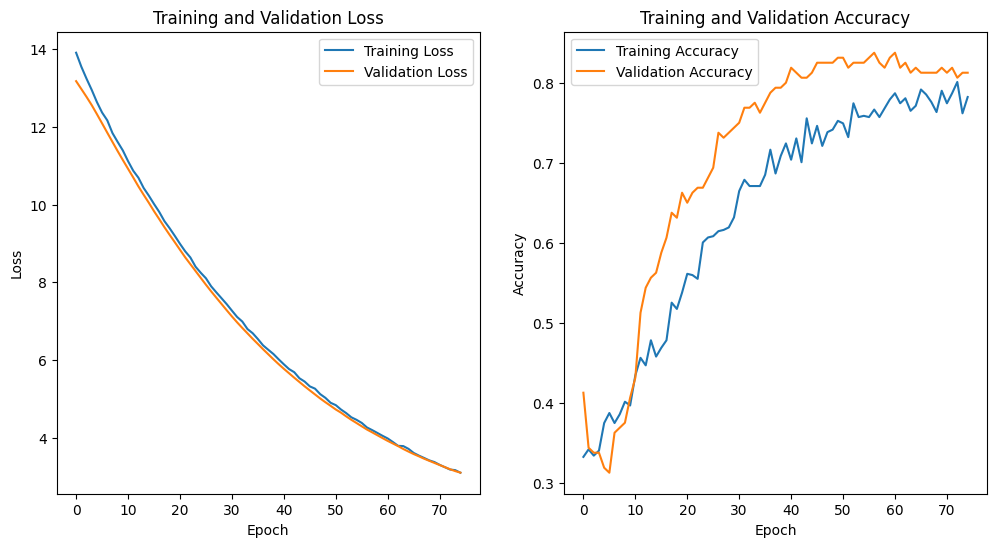

In [62]:
import matplotlib.pyplot as plt

# Plot training and validation loss
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Training Loss')
if 'val_loss' in history.history:
    plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

# Plot training and validation accuracy
plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Training Accuracy')
if 'val_accuracy' in history.history:
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.show()



In [63]:
from sklearn.metrics import f1_score, roc_auc_score, precision_recall_curve, auc
from keras.utils import to_categorical


# Evaluate the model on the test data
loss, accuracy = model.evaluate(X_test, y_test)
print(f"Accuracy: {accuracy}")
print(f"Loss: {loss}")

# Predictions for the test set
y_pred_probs = model.predict(X_test)
y_pred_classes = y_pred_probs.argmax(axis=1)
y_test_classes = y_test.argmax(axis=1)

# Calculate F1 scores
f1_micro = f1_score(y_test_classes, y_pred_classes, average='micro')
f1_macro = f1_score(y_test_classes, y_pred_classes, average='macro')
print(f"F1 Micro: {f1_micro}")
print(f"F1 Macro: {f1_macro}")

# Calculate AUC-ROC (one-vs-rest for multi-class)
roc_auc_ovr = roc_auc_score(y_test, y_pred_probs, multi_class='ovr')
print(f"AUC-ROC (One-vs-Rest): {roc_auc_ovr}")

# Calculate AUC-PR (one-vs-rest for multi-class)
precision = dict()
recall = dict()
auc_pr = dict()

for i in range(y_test.shape[1]):
    precision[i], recall[i], _ = precision_recall_curve(y_test[:, i], y_pred_probs[:, i])
    auc_pr[i] = auc(recall[i], precision[i])

# Average AUC-PR across all classes
auc_pr_avg = sum(auc_pr.values()) / len(auc_pr)
print(f"AUC-PR (Average): {auc_pr_avg}")


11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 764us/step - accuracy: 0.7526 - loss: 3.2296
Accuracy: 0.7405247688293457
Loss: 3.230970621109009
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
F1 Micro: 0.7405247813411079
F1 Macro: 0.317300862506342
AUC-ROC (One-vs-Rest): 0.5920928034013108
AUC-PR (Average): 0.36611985810641406


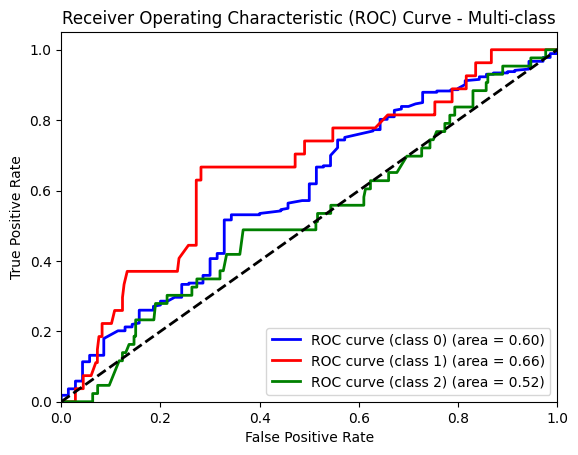

In [64]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize

# Assume `y_test_classes` and `y_pred_probs` have already been computed
# Example: y_test_classes = y_test.argmax(axis=1), y_pred_probs = model.predict(X_test)

# Binarize the output
y_test_binarized = label_binarize(y_test_classes, classes=[0, 1, 2])
n_classes = y_test_binarized.shape[1]

# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()

for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test_binarized[:, i], y_pred_probs[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plotting all ROC curves
plt.figure()

colors = ['blue', 'red', 'green']
for i, color in zip(range(n_classes), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=2,
             label=f'ROC curve (class {i}) (area = {roc_auc[i]:0.2f})')

plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve - Multi-class')
plt.legend(loc="lower right")
plt.show()


# another test

In [57]:
# Define a the best model of parameter


# {'batch_size': 40, 'epochs': 50, 'model__dropout_rate': 0.0, 'model__l2_reg': 0.01, 'model__learning_rate': 0.0001, 'model__units': (64, 64, 128)}
def create_best_model():
    model = Sequential()
    
    # First layer (input and hidden)
    model.add(Dense(64, input_dim=X_train.shape[1], activation='relu', 
                    kernel_regularizer=l2(0.01)))
    model.add(BatchNormalization())
    model.add(Dropout(0))
    
    # Additional hidden layers based on the length of units
    model.add(Dense(64, activation='relu', kernel_regularizer=l2(0.01)))
    model.add(BatchNormalization())
    model.add(Dropout(0))
    
    # Additional hidden layers based on the length of units
    model.add(Dense(128, activation='relu', kernel_regularizer=l2(0.01)))
    model.add(BatchNormalization())
    model.add(Dropout(0))
    
    # Output layer
    model.add(Dense(3, activation='softmax'))
    
    optimizer = Adam(learning_rate=0.0001)
    model.compile(optimizer=optimizer, 
                  loss='categorical_crossentropy', 
                  metrics=['accuracy'])
    
    return model


# Create the model
model = create_best_model()


# Fit the model
# Example of fitting a model with a validation split
history = model.fit(X_train, y_train, epochs=50, batch_size=40, validation_split= 0.2, verbose=1)

Epoch 1/50


c:\Users\crist\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


16/16 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - accuracy: 0.3764 - loss: 3.8580 - val_accuracy: 0.2313 - val_loss: 3.4492
Epoch 2/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.4010 - loss: 3.7441 - val_accuracy: 0.2688 - val_loss: 3.4368
Epoch 3/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.3946 - loss: 3.6134 - val_accuracy: 0.3000 - val_loss: 3.4245
Epoch 4/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.4280 - loss: 3.5115 - val_accuracy: 0.3000 - val_loss: 3.4095
Epoch 5/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.4443 - loss: 3.4677 - val_accuracy: 0.3187 - val_loss: 3.3896
Epoch 6/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.4571 - loss: 3.4340 - val_accuracy: 0.3625 - val_loss: 3.3661
Epoch 7/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.4607 - loss: 3.3922 - val_accuracy: 0.4062 - val_loss: 3.3436
Epoch 8/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.4830 - loss: 3.3245 - val_accuracy: 0.4437 - val_loss: 3.3194
Ep

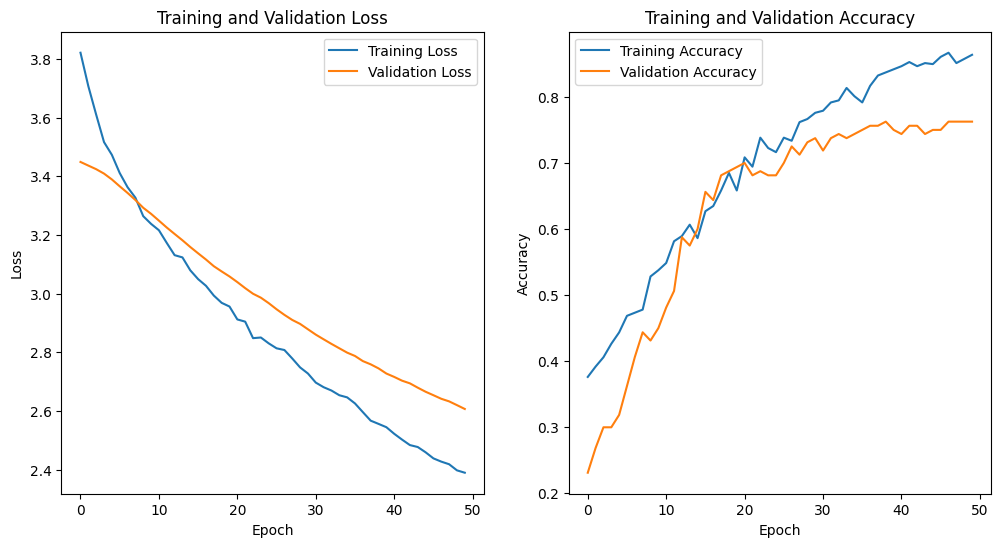

In [58]:
import matplotlib.pyplot as plt

# Plot training and validation loss
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Training Loss')
if 'val_loss' in history.history:
    plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

# Plot training and validation accuracy
plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Training Accuracy')
if 'val_accuracy' in history.history:
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.show()



In [59]:
from sklearn.metrics import f1_score, roc_auc_score, precision_recall_curve, auc
from keras.utils import to_categorical


# Evaluate the model on the test data
loss, accuracy = model.evaluate(X_test, y_test)
print(f"Accuracy: {accuracy}")
print(f"Loss: {loss}")

# Predictions for the test set
y_pred_probs = model.predict(X_test)
y_pred_classes = y_pred_probs.argmax(axis=1)
y_test_classes = y_test.argmax(axis=1)

# Calculate F1 scores
f1_micro = f1_score(y_test_classes, y_pred_classes, average='micro')
f1_macro = f1_score(y_test_classes, y_pred_classes, average='macro')
print(f"F1 Micro: {f1_micro}")
print(f"F1 Macro: {f1_macro}")

# Calculate AUC-ROC (one-vs-rest for multi-class)
roc_auc_ovr = roc_auc_score(y_test, y_pred_probs, multi_class='ovr')
print(f"AUC-ROC (One-vs-Rest): {roc_auc_ovr}")

# Calculate AUC-PR (one-vs-rest for multi-class)
precision = dict()
recall = dict()
auc_pr = dict()

for i in range(y_test.shape[1]):
    precision[i], recall[i], _ = precision_recall_curve(y_test[:, i], y_pred_probs[:, i])
    auc_pr[i] = auc(recall[i], precision[i])

# Average AUC-PR across all classes
auc_pr_avg = sum(auc_pr.values()) / len(auc_pr)
print(f"AUC-PR (Average): {auc_pr_avg}")


11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 791us/step - accuracy: 0.6437 - loss: 2.8684
Accuracy: 0.6647230386734009
Loss: 2.8259799480438232
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
F1 Micro: 0.6647230320699709
F1 Macro: 0.37805049388744677
AUC-ROC (One-vs-Rest): 0.5593202512972058
AUC-PR (Average): 0.35973503027445947


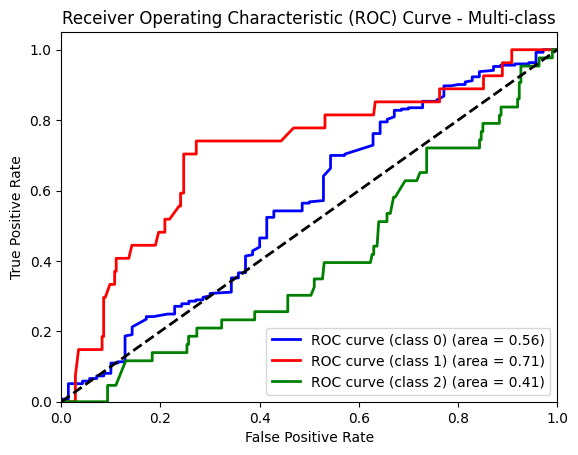

In [60]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize

# Assume `y_test_classes` and `y_pred_probs` have already been computed
# Example: y_test_classes = y_test.argmax(axis=1), y_pred_probs = model.predict(X_test)

# Binarize the output
y_test_binarized = label_binarize(y_test_classes, classes=[0, 1, 2])
n_classes = y_test_binarized.shape[1]

# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()

for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test_binarized[:, i], y_pred_probs[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plotting all ROC curves
plt.figure()

colors = ['blue', 'red', 'green']
for i, color in zip(range(n_classes), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=2,
             label=f'ROC curve (class {i}) (area = {roc_auc[i]:0.2f})')

plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve - Multi-class')
plt.legend(loc="lower right")
plt.show()
